In [15]:
import pandas as pd
import torch
import os
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [5]:
# --- 1. DETECT LOCATION MODEL ---
print("=== MENCARI LOKASI MODEL ===")
found_model_path = None
base_dir = os.getcwd()

# Cari di folder saat ini dan subfoldernya
for root, dirs, files in os.walk(base_dir):
    # Harus ada config.json DAN (pytorch_model.bin ATAU model.safetensors)
    if "config.json" in files:
        if "pytorch_model.bin" in files or "model.safetensors" in files:
            found_model_path = root
            print(f"[BERHASIL] Model lengkap ditemukan di: {found_model_path}")
            break

if found_model_path is None:
    raise FileNotFoundError(
        "CRITICAL ERROR: Tidak ditemukan file model (pytorch_model.bin/model.safetensors). "
        "Pastikan proses Training di Tugas 4 sampai tahap 'model.save_pretrained' sukses."
    )

=== MENCARI LOKASI MODEL ===
[BERHASIL] Model lengkap ditemukan di: c:\Backup Data\Rafi\Its\sem 7\ProjectA_TJ-Transjakarta_PBA2025-gasal\Notebooks\model_transjakarta_weighted


In [9]:
# --- 2. LOAD MODEL dan DATA ---
print(f"\nLoading model dari: {found_model_path}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    model = BertForSequenceClassification.from_pretrained(found_model_path).to(device)
    tokenizer = BertTokenizer.from_pretrained(found_model_path)
except Exception as e:
    print(f"Error saat loading model: {e}")
    raise e

print("Persiapan Data Test...")
try:
    df_text = pd.read_csv('../Data/hasil_preprocessing_bert.csv', sep=',', on_bad_lines='skip')
    df_label = pd.read_csv('../Data/hasil_pelabelan_transjakarta.csv', sep=',', on_bad_lines='skip')
    
    col_text = 'Isi Berita' if 'Isi Berita' in df_text.columns else df_text.columns[0]
    col_label = 'Sentimen' if 'Sentimen' in df_label.columns else df_label.columns[-1]
    
    df_text = df_text[[col_text]].rename(columns={col_text: 'text'})
    df_label = df_label[[col_label]].rename(columns={col_label: 'label_str'})
    
    # Merge
    min_len = min(len(df_text), len(df_label))
    df = pd.concat([df_text.iloc[:min_len], df_label.iloc[:min_len]], axis=1).dropna()
    
    # Filter dan Map
    df['label_str'] = df['label_str'].astype(str).str.lower().str.strip()
    df = df[df['label_str'].isin(['positif', 'negatif', 'netral'])].copy()
    
    label_map = {'negatif': 0, 'netral': 1, 'positif': 2}
    inv_label_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
    df['label'] = df['label_str'].map(label_map).astype(int)

    # SPLIT (Random State 42 agar sama dengan Training)
    _, temp_texts, _, temp_labels = train_test_split(
        df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42, stratify=df['label']
    )
    _, test_texts, _, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    
    print(f"Data Test Siap: {len(test_texts)} baris.")

except Exception as e:
    print(f"Error persiapan data: {e}")
    raise e


Loading model dari: c:\Backup Data\Rafi\Its\sem 7\ProjectA_TJ-Transjakarta_PBA2025-gasal\Notebooks\model_transjakarta_weighted
Persiapan Data Test...
Data Test Siap: 15 baris.


In [14]:
# --- 3. PREDIKSI dan ANALISIS ERROR ---
print("Menjalankan prediksi...")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
input_ids = test_encodings['input_ids'].to(device)
attention_mask = test_encodings['attention_mask'].to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

print("\n=== HASIL ANALISIS ERROR ===")
error_count = 0
for i in range(len(test_texts)):
    if test_labels[i] != preds[i]:
        error_count += 1
        print(f"\n[KASUS {error_count}]")
        print(f"Teks      : {test_texts[i]}")
        print(f"Label Asli: {inv_label_map[test_labels[i]]}")
        print(f"Prediksi  : {inv_label_map[preds[i]]}")
        print("-" * 40)
        
        if error_count >= 10:
            break

if error_count == 0:
    print("Tidak ditemukan kesalahan prediksi pada 5 data pertama.")
else:
    print(f"\nTotal kesalahan yang ditampilkan: {error_count}")

Menjalankan prediksi...

=== HASIL ANALISIS ERROR ===

[KASUS 1]
Teks      : Fraksi NasDem DPRD DKI Jakarta mendorongTransJakartamelakukan evaluasi menyeluruh usai 3 bus mengalami kecelakaan dalam sebulan. NasDem menekankan TransJakarta harus memperhatikan keselamatan penumpang.
"Menurut saya ada beberapa hal yang harus dilakukan pembenahan internal oleh seluruh jajaran Direksi TransJakarta, karena menyangkut keselamatan nyawa banyak orang," kata Ketua Fraksi NasDem DKI Jakarta Ahmad Lukman Jupiter kepada wartawan, Senin (22/9/2025).

SCROLL TO CONTINUE WITH CONTENT
Pertama, Jupiter meminta agar evaluasi menyeluruh sistem keamanan. Dia meminta audit seluruh armadaTransJakarta.
"Audit internal dan eksternal terhadap seluruh armada, termasuk kondisi bus, sistem rem, dan perawatan rutin. Pemeriksaan standar operasional prosedur (SOP) keselamatan, baik di lapangan maupun di pusat kontrol. Melibatkan Kementerian Perhubungan/Dishub DKI untuk memberikan rekomendasi teknis independen," tutur d

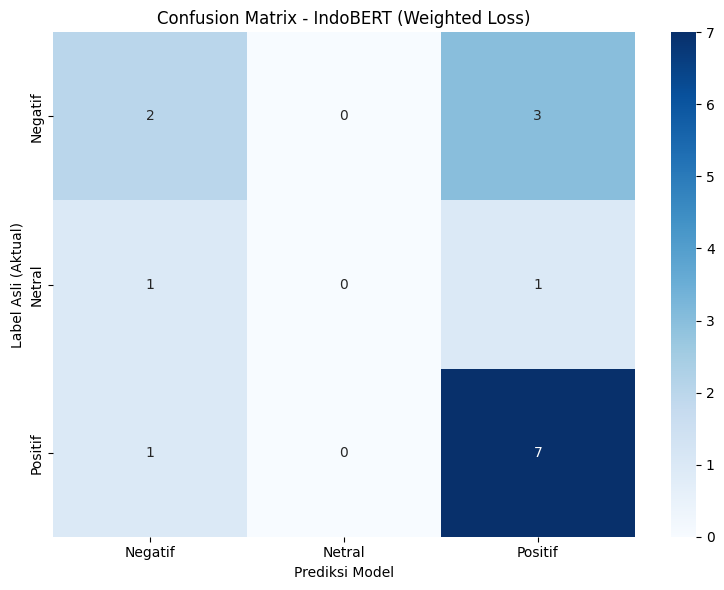

In [16]:
# --- 4. PLOT CONFUSION MATRIX ---
# Label mapping
labels = ['Negatif', 'Netral', 'Positif']

# Buat Confusion Matrix
cm = confusion_matrix(test_labels, preds)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli (Aktual)')
plt.title('Confusion Matrix - IndoBERT (Weighted Loss)')
plt.tight_layout()
plt.savefig('confusion_matrix_bert_final.png')
plt.show()